In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
label = pd.read_csv('Imagelabels.csv',header=None)

In [ ]:
label

,0
0,0
1,0
2,0
3,0
4,0
...,...
1595,24
1596,24
1597,24
1598,24


In [ ]:
label[0].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int64)

In [ ]:
for i in label[0].unique():
    print(i, label[0].value_counts()[i])

0 64
1 64
2 64
3 64
4 64
5 64
6 64
7 64
8 64
9 64
10 64
11 64
12 64
13 64
14 64
15 64
16 64
17 64
18 64
19 64
20 64
21 64
22 64
23 64
24 64


# Perfectly Balanced

In [ ]:
# Get list of image files
image_dir = 'scalogram'
image_files = os.listdir(image_dir)

# Match labels with image paths
image_paths = []
for img_file in image_files:
    image_paths.append(os.path.join(image_dir, img_file))

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(label)

c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Example data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Load images
images = []
for img_path in image_paths:
    img = cv2.imread(img_path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (64, 64))  # Resize image if necessary
    images.append(img)

images = np.array(images)

In [ ]:
img.shape

(64, 64, 3)

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, label, test_size=0.3, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
# Fit the augmentation method on the training data
datagen.fit(X_train)

In [ ]:
# Configure the generator to continuously generate augmented images
data_generator = datagen.flow(X_train, y_train, batch_size=32)

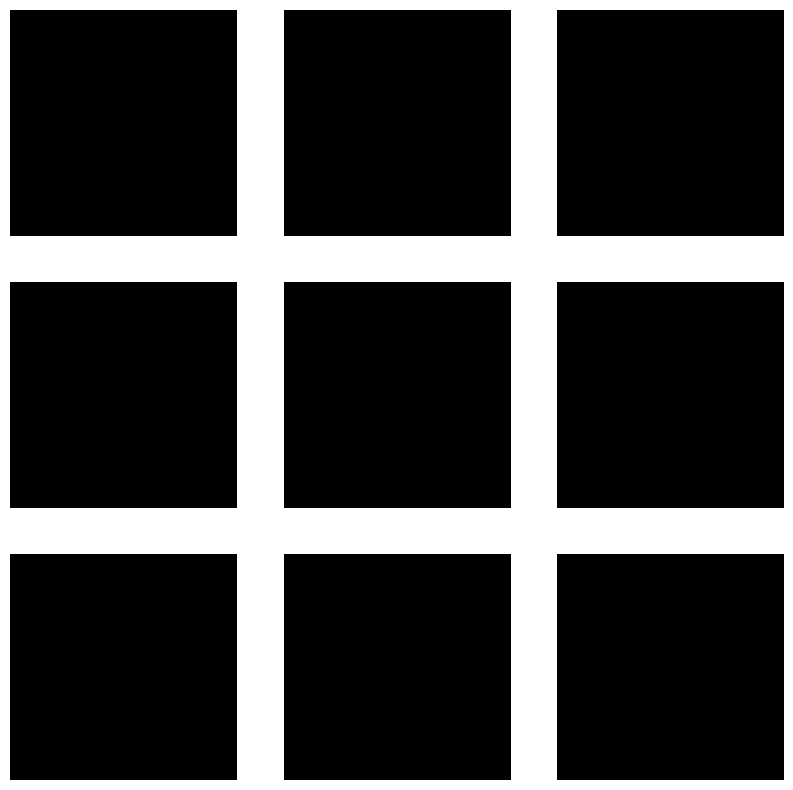

In [ ]:
# Visualize some augmented images
num_samples = 9
plt.figure(figsize=(10, 10))
for i in range(num_samples):
    plt.subplot(3, 3, i+1)
    batch = data_generator.next()
    image = batch[0][0]  # Choose the first image in the batch
    plt.imshow(np.uint8(image))
    plt.axis('off')
plt.show()

In [ ]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64,3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),  # Added convolutional layer
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dropout layer for regularization
    Dense(25, activation='softmax')  # 25 classes
])


In [ ]:
# Compile model
optimizer = Adam(learning_rate=0.0001)  # Adjust learning rate if needed
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
70/70 [==============================] - 5s 45ms/step - loss: 3.2216 - accuracy: 0.0464 - val_loss: 3.2116 - val_accuracy: 0.0667
Epoch 2/50
70/70 [==============================] - 3s 36ms/step - loss: 3.2050 - accuracy: 0.0580 - val_loss: 3.1971 - val_accuracy: 0.1208
Epoch 3/50
70/70 [==============================] - 3s 37ms/step - loss: 3.1816 - accuracy: 0.0902 - val_loss: 3.1657 - val_accuracy: 0.1562
Epoch 4/50
70/70 [==============================] - 3s 37ms/step - loss: 3.1362 - accuracy: 0.1143 - val_loss: 3.1019 - val_accuracy: 0.1542
Epoch 5/50
70/70 [==============================] - 2s 36ms/step - loss: 3.0491 - accuracy: 0.1473 - val_loss: 3.0184 - val_accuracy: 0.1458
Epoch 6/50
70/70 [==============================] - 3s 36ms/step - loss: 2.9645 - accuracy: 0.1607 - val_loss: 2.9047 - val_accuracy: 0.1792
Epoch 7/50
70/70 [==============================] - 3s 36ms/step - loss: 2.8715 - accuracy: 0.1857 - val_loss: 2.8405 - val_accuracy: 0.1813
Epoch 8/50
70

Text(0, 0.5, 'Accuracy')

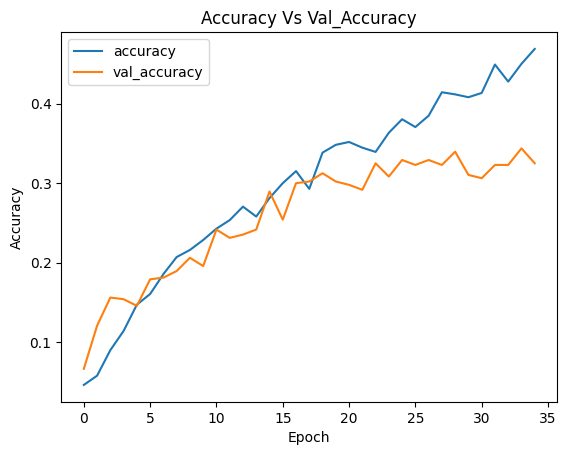

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(["accuracy","val_accuracy"])
plt.title('Accuracy Vs Val_Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

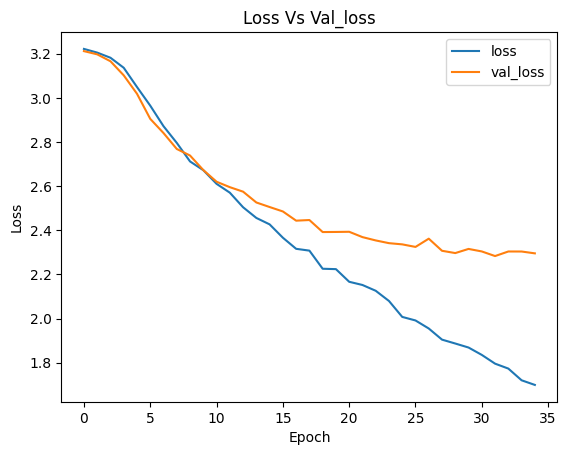

In [ ]:
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(["loss","val_loss"])
plt.title('Loss Vs Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

15/15 [==============================] - 0s 18ms/step - loss: 2.2832 - accuracy: 0.3229
Test Loss: 2.2832024097442627
Test Accuracy: 0.3229166567325592


In [ ]:
# Generate predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

15/15 [==============================] - 0s 17ms/step


In [ ]:
label[0]

0        0
1        0
2        0
3        0
4        0
        ..
1595    24
1596    24
1597    24
1598    24
1599    24
Name: 0, Length: 1600, dtype: int64

In [ ]:
# Convert label_encoder.classes_ to a list of strings
class_names = [str(class_name) for class_name in label_encoder.classes_]

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=class_names))

              precision    recall  f1-score   support

           0       0.12      0.12      0.12        17
           1       0.17      0.15      0.16        20
           2       0.21      0.19      0.20        16
           3       0.20      0.24      0.22        21
           4       0.15      0.18      0.16        22
           5       0.00      0.00      0.00        27
           6       0.22      0.11      0.15        18
           7       0.11      0.10      0.10        21
           8       0.35      0.59      0.44        22
           9       0.70      0.70      0.70        27
          10       0.00      0.00      0.00        15
          11       0.05      0.06      0.05        18
          12       0.11      0.21      0.15        14
          13       0.56      0.64      0.60        14
          14       0.04      0.06      0.05        16
          15       0.00      0.00      0.00        17
          16       0.14      0.29      0.19        17
          17       0.30    